# Clustering Analysis on the metadata of the Covid 19 Research Papers

In [36]:
import glob
import json
import csv
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# Handling the mulitple language used in the different paper on the same domain/area of study

from tqdm import tqdm
from langdetect import detect
from langdetect import DetectorFactory

plt.style.use('ggplot')
# figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

In [2]:
root_path = 'C:/Users/Dell/Desktop/Covid-19/CORD-19-research-challenge'
metadata_path = f'{root_path}\metadata.csv'
meta_df= pd.read_csv(metadata_path,dtype={
    'pubmed_id':str,
    'Microsoft Academic Paper ID':str,
    'doi':str   
})


#### get the all json file paths

In [140]:
all_json= glob.glob(f'{root_path}/**/*.json',recursive=True)
len(all_json)

33375

In [113]:
# to Lower Function to convert the references and title to lower case for smplicity
def lower_case(input_str):
    input_str = input_str.lower()
    return input_str

def get_breaks(content,length):
    data = ""
    words = content.split(' ')
    total_chars = 0
    for i in range(len(words)):
        total_chars += len(words[i])
        if total_chars > length:
            data = data + "<br>" + words[i]
            total_chars = 0
        else:
            data += " " + words[i]
    return data

###### Helper Function to read the files

In [117]:
class FileReader:
    def __init__(self,file_path):
        with open(file_path) as file:
            content = json.load(file)
            self.paper_id = content['paper_id'].strip()
            self.title = content['metadata']['title'].strip()
            self.abstract = []
            self.body_text = []
            self.references = []

            # Abstract
            for entry in content['abstract']:
                self.abstract.append(entry['text'])
            # Body text
            for entry in content['body_text']:
                self.body_text.append(entry['text'])

            # add the each reference name in the reference list
            for key,value in enumerate(content['bib_entries']):
                self.references.append(lower_case(content['bib_entries'][value]['title'].strip()))
                
            self.abstract= '\n'.join(self.abstract)
            self.body_text = '\n'.join(self.body_text)
            self.references = '\n'.join(self.references)
    
    def __repr__(self):
        return f'{self.paper_id}: {self.title[:200]}...'

In [74]:
# Print the first row of the Data set
first_row =  FileReader(all_json[0])
print(first_row.references);

genetic economy in 598 picornaviruses: foot-and-mouth disease virus replication exploits alternative precursor 599 cleavage pathways
a universal protocol to 602 generate consensus level genome sequences for foot-and-mouth disease virus and other 603 positive-sense polyadenylated rna viruses using the illumina miseq
library preparation for highly accurate population 606 sequencing of rna viruses
idba-ud: a de novo assembler for 608 single-cell and metagenomic sequencing data with highly uneven depth
basic local alignment 611 search tool
genetically engineered foot-and-613 mouth disease viruses with poly(c) tracts of two nucleotides are virulent in mice
both cis and trans activities of foot-and-mouth disease virus 617 3d polymerase are essential for viral rna replication
mutational analysis of the 619 mengovirus poly(c) tract and surrounding heteropolymeric sequences
no reuse allowed without permission. the copyright holder for this preprint (which was not peer-reviewed) is the
figure 3.

In [77]:
# Create a Dataframe of the complete database
dict_ = {
        'paper_id':[],
        'abstract':[],
        'body_text':[],
        'authors':[],
        'references':[],
        'title':[],
        'journal':[],
        'abstract_summary':[]
    }


for idx,entry in enumerate(all_json):
    if idx % (len(all_json)//10) == 0:
        print(f'Processing index : {idx} of {len(all_json)}')
    content = FileReader(entry)
    
    # get the metadata information
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    # no metadata., skip the paper
    if len(meta_data) == 0:
        continue
    
    dict_['paper_id'].append(content.paper_id)
    dict_['abstract'].append(content.abstract)
    dict_['body_text'].append(content.body_text)
    dict_['references'].append(content.references)
                     
    # also create the a column for the summary of abstract to be used in a plot
    if len(content.abstract) == 0:
        dict_['abstract_summary'].append("Not Provided.")
    elif len(content.abstract.split(' ')) > 100:
        info = content.abstract.split(' ')[:100]
        summary = get_breaks(' '.join(info), 40)
        dict_['abstract_summary'].append(summary + "...")
    else:
        # abstract is short enough
        summary = get_breaks(content.abstract, 40)
        dict_['abstract_summary'].append(summary)
    
    # get metadata information
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    
    try:
        # if more than one author
        authors = meta_data['authors'].values[0].split(';')
        if len(authors) > 2:
            # more than 2 authors, may be problem when plotting, so take first 2 append with ...
            dict_['authors'].append(". ".join(authors[:2]) + "...")
        else:
            # authors will fit in plot
            dict_['authors'].append(". ".join(authors))
    except Exception as e:
        # if only one author - or Null valie
        dict_['authors'].append(meta_data['authors'].values[0])
    
    # add the title information, add breaks when needed
    try:
        title = meta_data['title'].values[0]
        dict_['title'].append(title)
    # if title was not provided
    except Exception as e:
        dict_['title'].append(meta_data['title'].values[0])
    
    # add the journal information
    dict_['journal'].append(meta_data['journal'].values[0])

print("Completed Processing!")

Processing index : 0 of 33375
Processing index : 3337 of 33375
Processing index : 6674 of 33375
Processing index : 10011 of 33375
Processing index : 13348 of 33375
Processing index : 16685 of 33375
Processing index : 20022 of 33375
Processing index : 23359 of 33375
Processing index : 26696 of 33375
Processing index : 30033 of 33375
Processing index : 33370 of 33375
Completed Processing!


In [79]:
# Create the data frame out of the dictationary and save it to the file

df_covid = pd.DataFrame(dict_, columns=['paper_id', 'abstract', 'body_text', 'authors','references','title', 'journal', 'abstract_summary'])
df_covid.to_csv('Covid_19_Dataset_V1.csv')

# df_covid = pd.DataFrame.from_dict(dict_, orient='index')
# df_covid.transpose()

In [111]:
# load the csv file that contant the dataframe of the data created by me
custom_df =pd.read_csv('Covid_19_Dataset_V1.csv',index_col=0)
custom_df.head(2)

paper_id  \
0  0015023cc06b5362d332b3baf348d11567ca2fbb   
1  00340eea543336d54adda18236424de6a5e91c9d   

                                            abstract  \
0  word count: 194 22 Text word count: 5168 23 24...   
1  During the past three months, a new coronaviru...   

                                           body_text  \
0  VP3, and VP0 (which is further processed to VP...   
1  In December 2019, a novel coronavirus, SARS-Co...   

                                   authors  \
0  Joseph C. Ward.  Lidia Lasecka-Dykes...   
1          Carla Mavian.  Simone Marini...   

                                          references  \
0  genetic economy in 598 picornaviruses: foot-an...   
1  situation report -43\nemergence of a novel hum...   

                                               title journal  \
0  The RNA pseudoknots in foot-and-mouth disease ...     NaN   
1  Regaining perspective on SARS-CoV-2 molecular ...     NaN   

                                    abstract_summary  
0   word count: 194 22 Text word count: 5168 23 2...  
1   During the past three months, a new coronavir...

In [4]:
mask = (custom_df['title'].str.len() >= 5)
temp_df = custom_df.loc[mask]

In [114]:
# Functions to remove the special character from the title string 
import re
# feature engineering
custom_df['title'] = custom_df['title'].apply(lambda x: lower_case(str(x)))

In [115]:
custom_df.head(3)

paper_id  \
0  0015023cc06b5362d332b3baf348d11567ca2fbb   
1  00340eea543336d54adda18236424de6a5e91c9d   
2  004f0f8bb66cf446678dc13cf2701feec4f36d76   

                                            abstract  \
0  word count: 194 22 Text word count: 5168 23 24...   
1  During the past three months, a new coronaviru...   
2                                                NaN   

                                           body_text  \
0  VP3, and VP0 (which is further processed to VP...   
1  In December 2019, a novel coronavirus, SARS-Co...   
2  The 2019-nCoV epidemic has spread across China...   

                                   authors  \
0  Joseph C. Ward.  Lidia Lasecka-Dykes...   
1          Carla Mavian.  Simone Marini...   
2             Hanchu Zhou.  Jianan Yang...   

                                          references  \
0  genetic economy in 598 picornaviruses: foot-an...   
1  situation report -43\nemergence of a novel hum...   
2  world health organizations. novel coronavirus ...   

                                               title journal  \
0  the rna pseudoknots in foot-and-mouth disease ...     NaN   
1  regaining perspective on sars-cov-2 molecular ...     NaN   
2  healthcare-resource-adjusted vulnerabilities t...     NaN   

                                    abstract_summary  
0   word count: 194 22 Text word count: 5168 23 2...  
1   During the past three months, a new coronavir...  
2                                      Not Provided.

In [ ]:
from collections import defaultdict

my_reference_dict = defaultdict(list)
matchCount = 0
for j in range(len(custom_df)):
    
    main_paper_id = custom_df.iloc[j, 0]
    title = custom_df.iloc[j,5]
    
    if j % (len(custom_df)//10) == 0:
        print(f'Processing index : {j} of {len(custom_df)}')
        matchCount = 0
    
    if len(title) >=5:
        for i in range(len(custom_df)):
            myRefPaperId = custom_df.iloc[i, 0]
            myReferences = custom_df.iloc[i,4]
            for line in myReferences.split('\n'):
                if title.lower() == line.lower():
                    matchCount = matchCount+1
                    my_reference_dict[main_paper_id].append(myRefPaperId)
                    print(f'Match Count: {matchCount}')
                    
print ("Completed")

In [133]:
# save the dict as csv
w = csv.writer(open("graphListV1.csv", "w"))
for key, val in my_reference_dict.items():
    w.writerow([key, val])
    
# save the dict as json
json = json.dumps(my_reference_dict)
f = open("graphListV1.json","w")
f.write(json)
f.close()

# save the dict as 
f = open("graphListV1.txt","w")
f.write(str(my_reference_dict))
f.close()

# # save the dict as pickle file
# f = open("graphListV1.pkl","wb")
# pickle.dump(my_reference_dict,f)
# f.close()

In [2]:
# read the json file stored on the local system

f = open('graphListV1.json') 

# returns JSON object as  
# a dictionary 
data = json.load(f) 

# display the data
# print(data)

In [3]:
# now parse the JSON object to create a dataframe for Graph plotting
fromList = []
toList = []

for key,value in data.items():
    for item in value:
        fromList.append(key)
        toList.append(item)
        
directed_df = pd.DataFrame({ 'from':fromList, 'to':toList})

In [4]:
# total Nodes in the Graph
node_list = set(fromList) 
len(node_list)

12866

In [5]:
# display the df
directed_df['to'].dropna()

0        8125e22d2dc5ad5fe51394fc08dc89212c833d2c
1        84efaac896e551763256fd4d16e56a99b416c175
2        ddba9808c2e5a41e0a27996ff5b59e4c09ae159a
3        d85d142716f7f85cd27b54fc38a9e2968cf14346
4        b1b9d81726e56c2781ce6b63ae5015cf2f314c6f
                           ...                   
83155    131af5ab50551638e3ce9a8c615b9b4364f2f34e
83156    45d70772bdf3ab4faa9fe6085aa92fb35af5b109
83157    0b90f302993b075229dbe5f9bc03a180b2e2632f
83158    e31fe1509bb347d50c56545d284cf09b6febfdb9
83159    efc1b7d8cc09b229c5cd7cda3a8ff8446e0d8b63
Name: to, Length: 83160, dtype: object

In [7]:
#plot the graph
plt.figure(figsize=(40,40))
G = nx.from_pandas_edgelist(directed_df[:20000], 'from', 'to', create_using=nx.DiGraph())

<Figure size 2880x2880 with 0 Axes>

## save the Graph creating

In [281]:
# save in the graphml format
nx.write_graphml(G, "covid.graphml")


# save in the edge list format
nx.write_edgelist(G, "covid.edgelist")

C:\Users\Dell\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\Dell\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


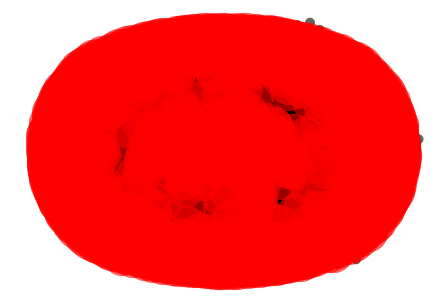

In [8]:
G1 = nx.from_pandas_edgelist(directed_df[:2000], 'from', 'to', create_using=nx.DiGraph())
pos = nx.spring_layout(G1)
colors = range(2000)
options = {
    "node_color": "red",
    "edge_color": 'black',
    "width": 10,
    "edge_cmap": plt.cm.Blues,
    "with_labels": False,
    "node_size":1500,
    "alpha":0.6, 
    "arrows":True,
    "arrowsize":30,
    "arrowstyle":'->'
}

nx.draw(G1,pos,**options)
ax = plt.gca()
ax.set_axis_off()
plt.show()

### Information of the Above Graph

In [9]:
nx.info(G)

'Name: \nType: DiGraph\nNumber of nodes: 10641\nNumber of edges: 19937\nAverage in degree:   1.8736\nAverage out degree:   1.8736'

In [10]:
nx.is_weakly_connected(G)

False

In [11]:
print("Number of Edges:",nx.number_of_edges(G))
print("Number of Nodes:",nx.number_of_nodes(G))
print("Average Clustering Coeffient:",round(nx.average_clustering(G),3))
print("Density of the Graph:",round(nx.density(G),3))

Number of Edges: 19937
Number of Nodes: 10641
Average Clustering Coeffient: 0.045
Density of the Graph: 0.0


### Degree Histogram

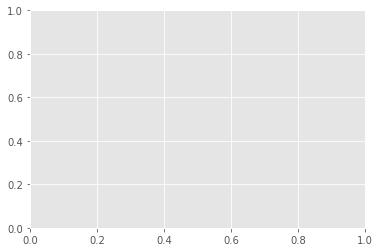

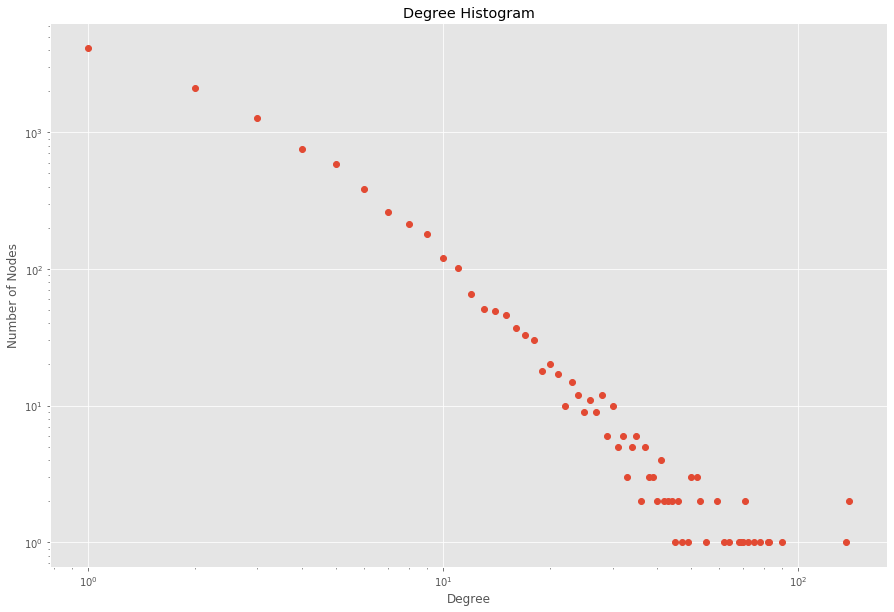

In [24]:
# Degree Histogram
import collections
degree_sequence = [d for n, d in G.degree()]  # degree sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()

plt.figure(figsize=(15,10))
plt.loglog(deg, cnt,'o')
plt.title("Degree Histogram")
plt.ylabel("Number of Nodes")
plt.xlabel("Degree")
plt.show()

## Degree Rank Plot

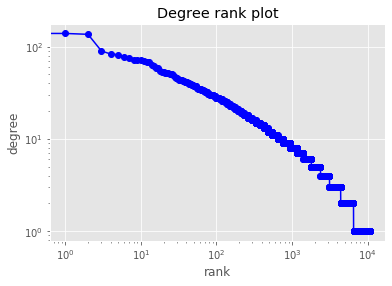

In [25]:
# degree= H.degree()
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
dmax = max(degree_sequence)

plt.loglog(degree_sequence, "b-", marker="o")
plt.title("Degree rank plot")
plt.ylabel("degree")
plt.xlabel("rank")
plt.show()

##  Betweenness,Degree centrality, Closeness centrality

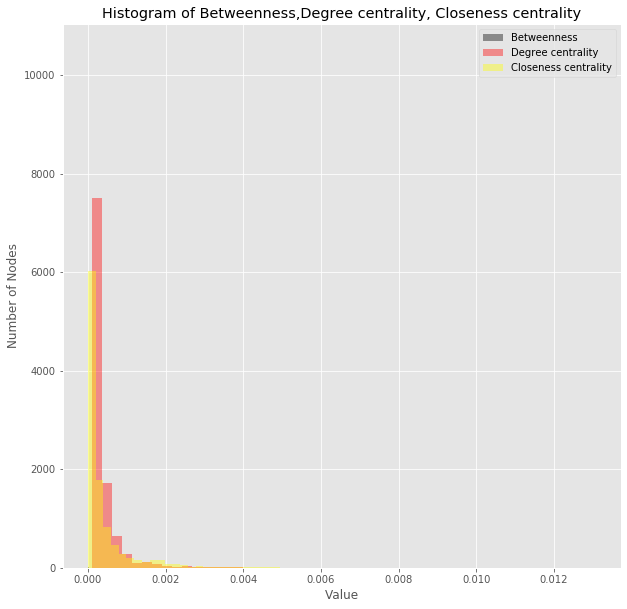

In [12]:
# Degree Centrality, Betweenness Centrality and Eigenvector centrality
# A central actor is one that acts as a bridge, broker or gatekeeper.
# A central actor is connected to other central actors.
# A central node is one that is close, on average, to other nodes.

# print("Betweenness")
b = list(nx.betweenness_centrality(G).values())

# for v in G.nodes():
#     print(f"{v:2} {b[v]:.3f}")

# print("Degree centrality")
d = list(nx.degree_centrality(G).values())
# for v in G.nodes():
#     print(f"{v:2} {d[v]:.3f}")

# print("Closeness centrality")
c = list(nx.closeness_centrality(G).values())
# for v in G.nodes():
#     print(f"{v:2} {c[v]:.3f}")

plt.figure(figsize=(10,10))

sns.distplot(a = b ,label='Betweenness',color='black',hist=True,kde=False)
sns.distplot(a = d ,label='Degree centrality',color='red',hist=True,kde=False)
sns.distplot(a = c ,label='Closeness centrality',color='yellow',hist=True,kde=False)

plt.ylabel("Number of Nodes")
plt.xlabel("Value")

# Add title
plt.title("Histogram of Betweenness,Degree centrality, Closeness centrality")

# Force legend to appear
plt.legend()

In [14]:
def Average(lst): 
    return sum(lst) / len(lst) 
  
avg_b1 = Average(b) 
avg_b1

avg_d1 = Average(d)

avg_c1 = Average(c)
print("Average Betweenness:",round(avg_b1,5))
print("Average Degree centrality",round(avg_d1,5))
print("Average Closeness centrality",round(avg_c1,5))

Average Betweenness: 0.0
Average Degree centrality 0.00035
Average Closeness centrality 0.00042


## Clustering Coefficient vs Degree

In [57]:
degrees = [d for n, d in G.degree()]
clusteringCoefficient = list(nx.clustering(G).values())
data = {'Degree':degrees, 'Clustering Coefficient':clusteringCoefficient} 

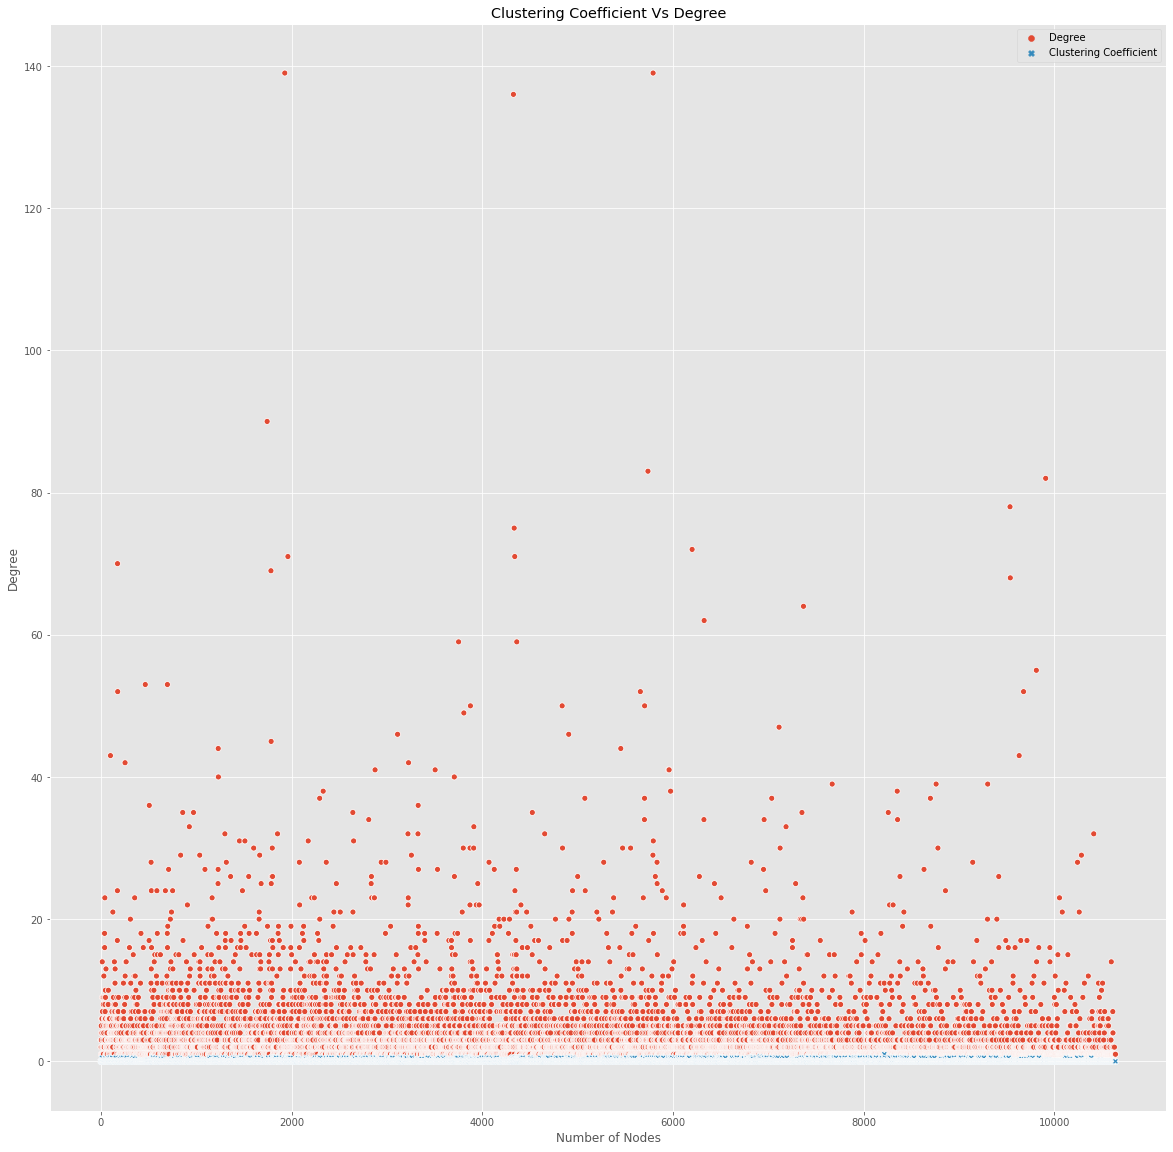

In [84]:
# Create DataFrame 
graph_df = pd.DataFrame(data,columns=['Degree','Clustering Coefficient']) 
graph_df.head(2)

plt.figure(figsize=(20,20))
plt.xlabel("Number of Nodes")
plt.ylabel("Degree")
plt.title("Clustering Coefficient Vs Degree")

# sns.scatter(data=df.column1, color="g")
# ax2 = plt.twinx()
# sns.lineplot(data=df.column2, color="b", ax=ax2)

ax = sns.scatterplot(data=graph_df)

In [92]:
print(f'Transitivity of the network: {round(nx.transitivity(G),3)}')
# print(f'Transitivity of the network: {round(nx.transitivity(G),3)}')

Transitivity of the network: 0.015


## Main Path analysis

In [18]:
# load the single connected giant graph
giantG = nx.read_pajek("SingleComponent.net")

In [19]:
largest_cc = max(nx.weakly_connected_components(giantG), key=len)
H = G.subgraph(largest_cc)

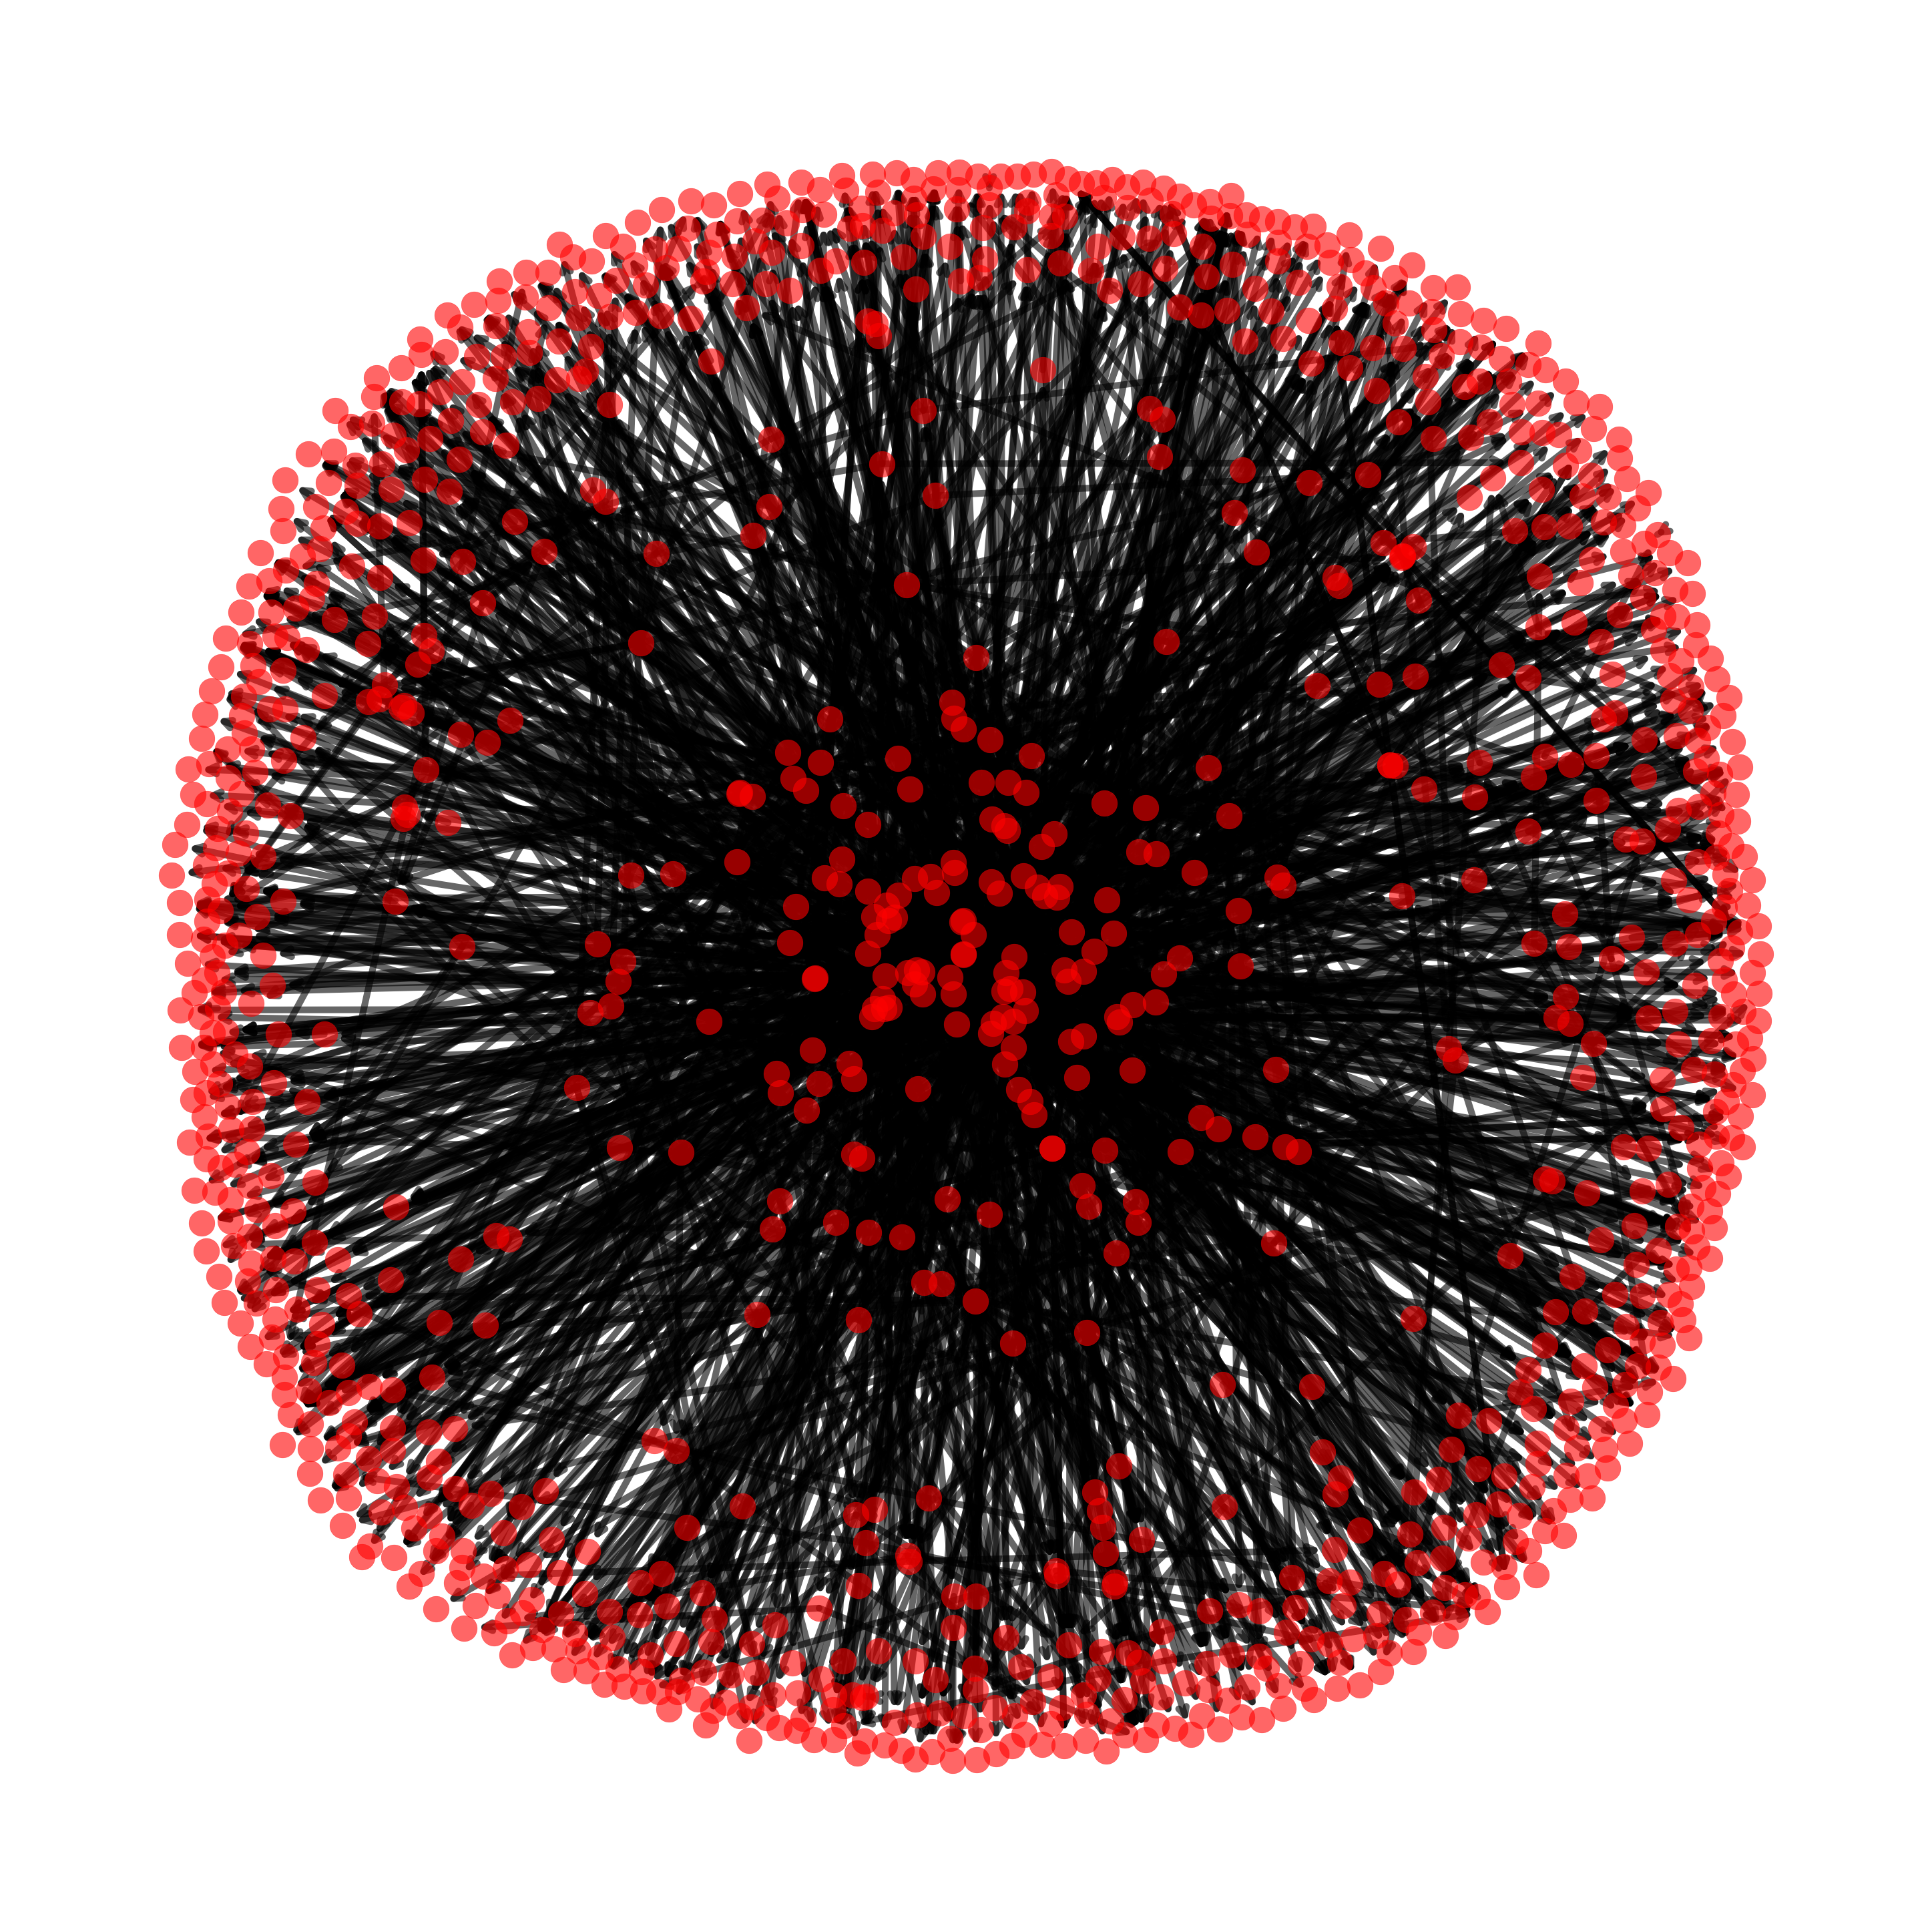

In [20]:
plt.figure(figsize=(40,40))
pos = nx.spring_layout(H)
colors = range(2000)
options = {
    "node_color": "red",
    "edge_color": 'black',
    "width": 10,
    "edge_cmap": plt.cm.Blues,
    "with_labels": False,
    "node_size":1500,
    "alpha":0.6, 
    "arrows":True,
    "arrowsize":30,
    "arrowstyle":'->'
}

nx.draw(H,pos,**options)
ax = plt.gca()
ax.set_axis_off()
plt.show()

In [93]:
nx.info(H)
print("Number of Edges:",nx.number_of_edges(H))
print("Number of Nodes:",nx.number_of_nodes(H))
print("Average Path length:",round(nx.average_shortest_path_length(H),5))
print("Average Clustering Coeffient:",round(nx.average_clustering(H),5))
print("Density of the Graph:",round(nx.density(H),5))

Number of Edges: 1903
Number of Nodes: 1133
Average Path length: 0.011
Average Clustering Coeffient: 0.0646
Density of the Graph: 0.00148


In [94]:
def avg_degree_cal(degree):
    count = 0
    for node,value in enumerate(degree):
        count= count+value[1]
    return round(count/len(degree),3)

## Comparison with the random Graphs

C:\Users\Dell\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


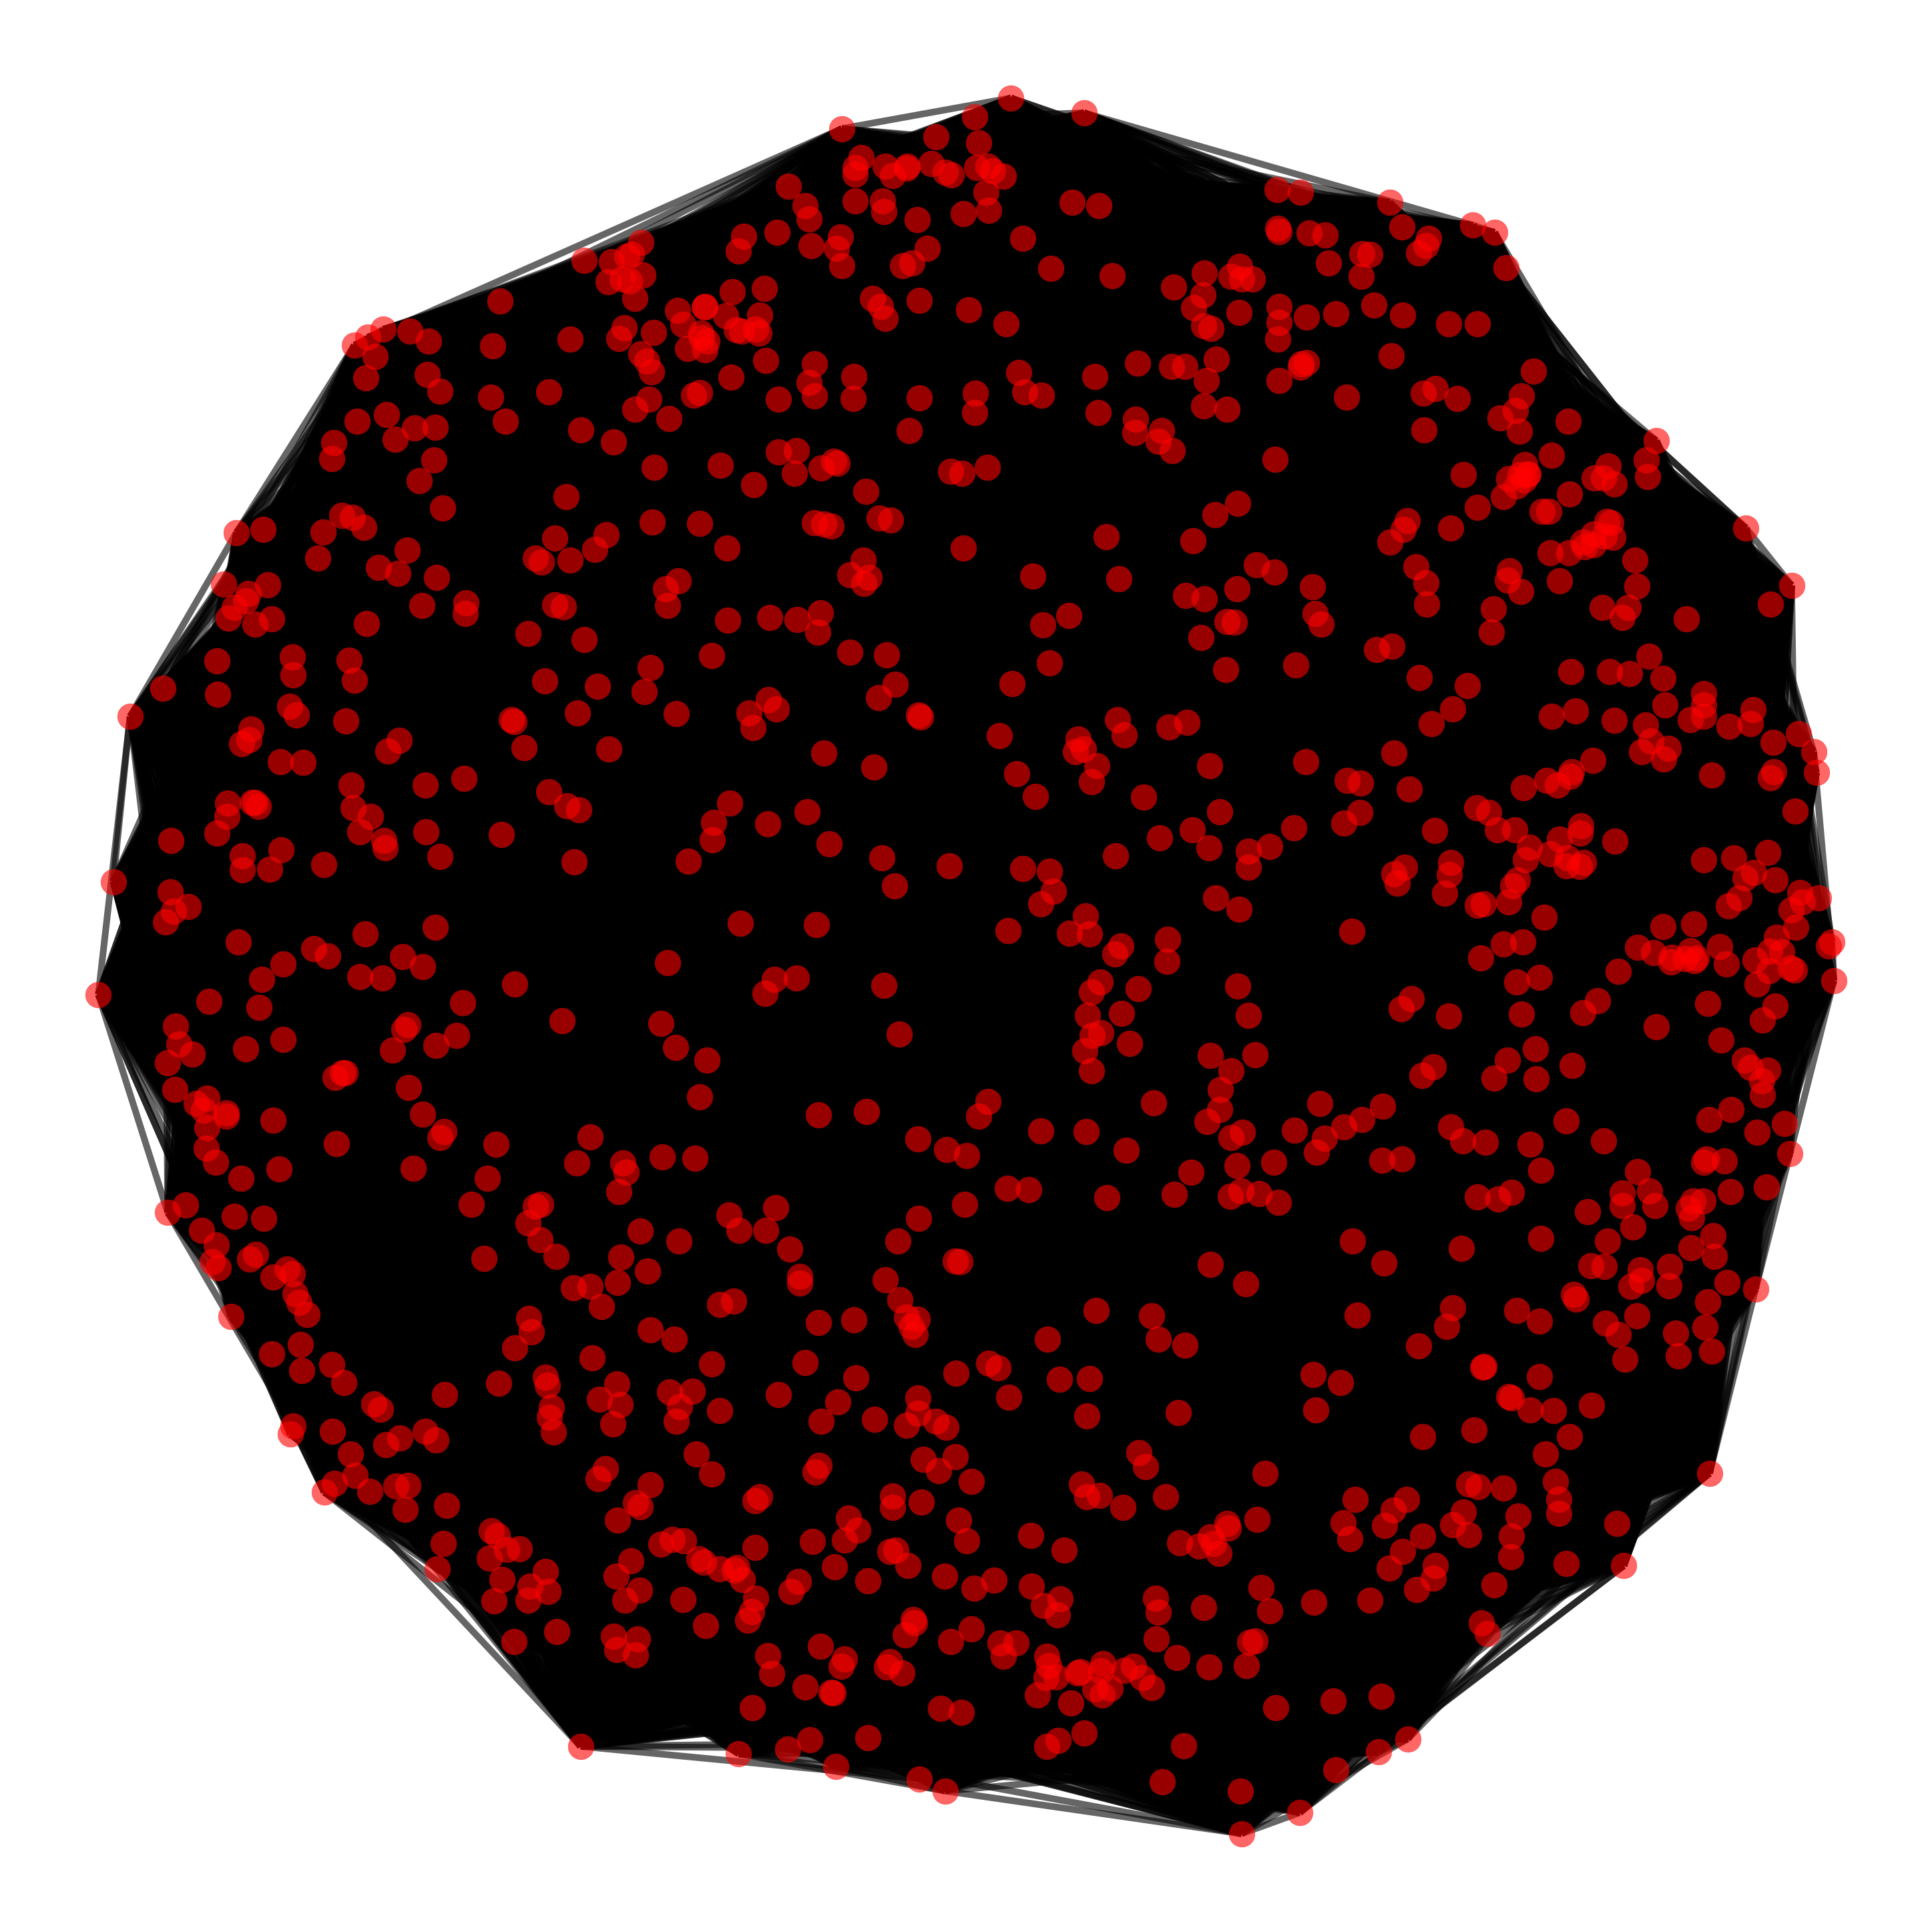

In [50]:

n = 1133
p = 0.36
rgraph = nx.gnp_random_graph(n,p)
plt.figure(figsize=(40,40))
pos = nx.spring_layout(rgraph)
colors = range(2000)
options = {
    "node_color": "red",
    "edge_color": 'black',
    "width": 10,
    "edge_cmap": plt.cm.Blues,
    "with_labels": False,
    "node_size":1500,
    "alpha":0.6, 
    "arrows":True,
    "arrowsize":30,
    "arrowstyle":'->'
}

nx.draw(rgraph,pos,**options)
ax = plt.gca()
ax.set_axis_off()
plt.show()

In [96]:
import random

# Create random graph with different probabilties
# let say we are checking on 100 random graph to compare with
testNumber = 25

avg_path_length = 0
avg_clustering_coefficient = []
avg_degree_distribution = 0
avg_density = 0
# connectivity with p = 0.2 

n = 1133

# p = random.random()
# print(f'Probability {p}')
# rand_graph = nx.gnp_random_graph(n,p)
# avg_path_length = avg_path_length+ round(nx.average_shortest_path_length(rand_graph),3)
# avg_clustering_coefficient = avg_clustering_coefficient + round(nx.average_clustering(rand_graph),3)
# avg_degree_distribution  = avg_degree_distribution + avg_degree_cal(rand_graph.degree())
# avg_density = avg_density + nx.density(rand_graph)

for i in range(testNumber):
    p = random.random()
    print(f'Probability {p}')
    rand_graph = nx.gnp_random_graph(n,p)
    avg_path_length = avg_path_length + round(nx.average_shortest_path_length(rand_graph),3)
    avg_clustering_coefficient.append(round(nx.average_clustering(rand_graph),3))
#     avg_degree_distribution  = avg_degree_distribution + avg_degree_disavg_degree_cal(rand_graph.degree())
#     avg_density = avg_density + nx.density(rand_graph)


Probability 0.27026456357285067
Probability 0.055565727385493036
Probability 0.32841803971173866
Probability 0.4313928674013441
Probability 0.1424661832017966
Probability 0.007824082662153065
Probability 0.9787584855657433
Probability 0.031538090111212225
Probability 0.7130004804636916
Probability 0.2892594499151375
Probability 0.49855536822695434
Probability 0.6722115845666854
Probability 0.711884052887269
Probability 0.1163128411644011
Probability 0.3896017174511224
Probability 0.617454322784367
Probability 0.278605354474345
Probability 0.18344340941975645
Probability 0.4453660997406882
Probability 0.08711891921988935
Probability 0.7402177904336869
Probability 0.3406187942283311
Probability 0.3755471624944716
Probability 0.13715595579566742
Probability 0.08079259230406044


In [97]:
avg_clustering_coefficient

[0.27,
 0.055,
 0.328,
 0.431,
 0.143,
 0.007,
 0.979,
 0.031,
 0.713,
 0.289,
 0.498,
 0.673,
 0.711,
 0.117,
 0.389,
 0.617,
 0.278,
 0.183,
 0.446,
 0.087,
 0.74,
 0.34,
 0.375,
 0.136,
 0.08]

In [105]:
print("Average Shortest Path:",round(avg_path_length/testNumber,3))
print("Mean Clustering Coefficient:",round(np.sum(avg_clustering_coefficient)/testNumber,3))

Average Shortest Path: 1.715
Mean Clustering Coefficient: 0.357


## Network Analysis

In [115]:
# some Feature Engineering
custom_df['abstract_word_count'] = custom_df['abstract'].apply(lambda x: len(str(x).strip().split()))  # word count in abstract
custom_df['body_word_count'] = custom_df['body_text'].apply(lambda x: len(str(x).strip().split()))  # word count in body
custom_df['body_unique_words']=custom_df['body_text'].apply(lambda x:len(set(str(x).split())))  # number of unique words in body
custom_df.head()

paper_id  \
0  0015023cc06b5362d332b3baf348d11567ca2fbb   
1  00340eea543336d54adda18236424de6a5e91c9d   
2  004f0f8bb66cf446678dc13cf2701feec4f36d76   
3  00d16927588fb04d4be0e6b269fc02f0d3c2aa7b   
4  0139ea4ca580af99b602c6435368e7fdbefacb03   

                                            abstract  \
0  word count: 194 22 Text word count: 5168 23 24...   
1  During the past three months, a new coronaviru...   
2                                                NaN   
3  Infectious bronchitis (IB) causes significant ...   
4  Nipah Virus (NiV) came into limelight recently...   

                                           body_text  \
0  VP3, and VP0 (which is further processed to VP...   
1  In December 2019, a novel coronavirus, SARS-Co...   
2  The 2019-nCoV epidemic has spread across China...   
3  Infectious bronchitis (IB), which is caused by...   
4  Nipah is an infectious negative-sense single-s...   

                                   authors  \
0  Joseph C. Ward.  Lidia Lasecka-Dykes...   
1          Carla Mavian.  Simone Marini...   
2             Hanchu Zhou.  Jianan Yang...   
3       Salman L. Butt.  Eric C. Erwood...   
4         Nishi Kumari.  Ayush Upadhyay...   

                                          references  \
0  genetic economy in 598 picornaviruses: foot-an...   
1  situation report -43\nemergence of a novel hum...   
2  world health organizations. novel coronavirus ...   
3  emergence of novel strains of avian infectious...   
4  molecular biology of hendra and nipah viruses\...   

                                               title journal  \
0  the rna pseudoknots in foot-and-mouth disease ...     NaN   
1  regaining perspective on sars-cov-2 molecular ...     NaN   
2  healthcare-resource-adjusted vulnerabilities t...     NaN   
3  real-time, minion-based, amplicon sequencing f...     NaN   
4  a combined evidence approach to prioritize nip...     NaN   

                                    abstract_summary  abstract_word_count  \
0   word count: 194 22 Text word count: 5168 23 2...                  241   
1   During the past three months, a new coronavir...                  175   
2                                      Not Provided.                    1   
3   Infectious bronchitis (IB) causes<br>signific...                 1647   
4   Nipah Virus (NiV) came into limelight recentl...                  326   

   body_word_count  body_unique_words  
0             1728                705  
1             2549               1072  
2              755                377  
3             4003               1185  
4             2399               1026

In [116]:
custom_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30197 entries, 0 to 30196
Data columns (total 11 columns):
paper_id               30197 non-null object
abstract               22513 non-null object
body_text              30197 non-null object
authors                29646 non-null object
references             30197 non-null object
title                  30197 non-null object
journal                29077 non-null object
abstract_summary       30197 non-null object
abstract_word_count    30197 non-null int64
body_word_count        30197 non-null int64
body_unique_words      30197 non-null int64
dtypes: int64(3), object(8)
memory usage: 2.8+ MB


In [117]:
# Handling the duplicates
custom_df.drop_duplicates(['abstract', 'body_text'], inplace=True)
custom_df['abstract'].describe(include='all')

count                                                 22507
unique                                                22479
top       publicly funded repositories, such as the WHO ...
freq                                                      4
Name: abstract, dtype: object

In [118]:
custom_df.describe()

abstract_word_count  body_word_count  body_unique_words
count         30184.000000     30184.000000       30184.000000
mean            167.423668      4820.864034        1447.541512
std             174.287570      7202.601394        1197.145123
min               1.000000         1.000000           1.000000
25%               1.000000      2489.000000         931.000000
50%             165.000000      3740.000000        1259.000000
75%             240.000000      5503.000000        1685.000000
max            5118.000000    260378.000000       38298.000000

In [119]:
custom_df.dropna(inplace=True)
custom_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21327 entries, 1053 to 30196
Data columns (total 11 columns):
paper_id               21327 non-null object
abstract               21327 non-null object
body_text              21327 non-null object
authors                21327 non-null object
references             21327 non-null object
title                  21327 non-null object
journal                21327 non-null object
abstract_summary       21327 non-null object
abstract_word_count    21327 non-null int64
body_word_count        21327 non-null int64
body_unique_words      21327 non-null int64
dtypes: int64(3), object(8)
memory usage: 2.0+ MB


In [147]:


# set seed
DetectorFactory.seed = 0

# hold label - language
languages = []

# go through each text
for ii in tqdm(range(0,len(custom_df))):
    # split by space into list, take the first x intex, join with space
    text = custom_df.iloc[ii]['body_text'].split(" ")
    
    lang = "en"
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))
    # ught... beginning of the document was not in a good format
    except Exception as e:
        all_words = set(text)
        try:
            lang = detect(" ".join(all_words))
        # what!! :( let's see if we can find any text in abstract...
        except Exception as e:
            
            try:
                # let's try to label it through the abstract then
                lang = detect(df.iloc[ii]['abstract_summary'])
            except Exception as e:
                lang = "unknown"
                pass
    
    # get the language    
    languages.append(lang)

  2%|████                                                                                                                                                                     | 511/20977 [00:25<17:18, 19.70it/s]


KeyboardInterrupt: 

In [121]:
from pprint import pprint

languages_dict = {}
for lang in set(languages):
    languages_dict[lang] = languages.count(lang)
    
print("Total: {}\n".format(len(languages)))
pprint(languages_dict)

Total: 21327

{'de': 14,
 'en': 20977,
 'es': 118,
 'fr': 195,
 'it': 10,
 'pl': 2,
 'pt': 10,
 'unknown': 1}


In [146]:
# plot different language used 

custom_df['language'] = languages
plt.bar(range(len(languages_dict)), list(languages_dict.values()), align='center')
plt.xticks(range(len(languages_dict)), list(languages_dict.keys()))
plt.title("Distribution of Languages in Dataset")
plt.xlabel("Languages")
plt.ylabel("Number of Papers")
plt.show()

ValueError: Length of values does not match length of index

In [123]:
# we only want to see the paper which are written in english only
custom_df = custom_df[custom_df['language'] == 'en']
custom_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20977 entries, 1053 to 30196
Data columns (total 12 columns):
paper_id               20977 non-null object
abstract               20977 non-null object
body_text              20977 non-null object
authors                20977 non-null object
references             20977 non-null object
title                  20977 non-null object
journal                20977 non-null object
abstract_summary       20977 non-null object
abstract_word_count    20977 non-null int64
body_word_count        20977 non-null int64
body_unique_words      20977 non-null int64
language               20977 non-null object
dtypes: int64(3), object(9)
memory usage: 2.1+ MB


In [124]:
#Download the spacy bio parser

from IPython.utils import io
with io.capture_output() as captured:
    !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_lg-0.2.4.tar.gz
        
#NLP 
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_sci_lg  # model downloaded in previous step

In [125]:
import string

punctuations = string.punctuation
stopwords = list(STOP_WORDS)
stopwords[:10]

['so',
 'either',
 'rather',
 'wherein',
 'his',
 'most',
 'but',
 'no',
 'hereupon',
 'she']

In [126]:
custom_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 
    'al.', 'Elsevier', 'PMC', 'CZI', 'www'
]

for w in custom_stop_words:
    if w not in stopwords:
        stopwords.append(w)

In [127]:
# Parser
parser = en_core_sci_lg.load(disable=["tagger", "ner"])
parser.max_length = 7000000

def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

In [128]:
tqdm.pandas()
test_df = custom_df[:5000]
test_df["processed_text"] = test_df["body_text"].progress_apply(spacy_tokenizer)

C:\Users\Dell\Anaconda3\lib\site-packages\tqdm\std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [30:40<00:00,  2.72it/s]
C:\Users\Dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


count     5000.000000
mean      4682.022400
std       2766.644659
min         53.000000
25%       3136.750000
50%       4276.500000
75%       5767.250000
max      83433.000000
Name: body_word_count, dtype: float64

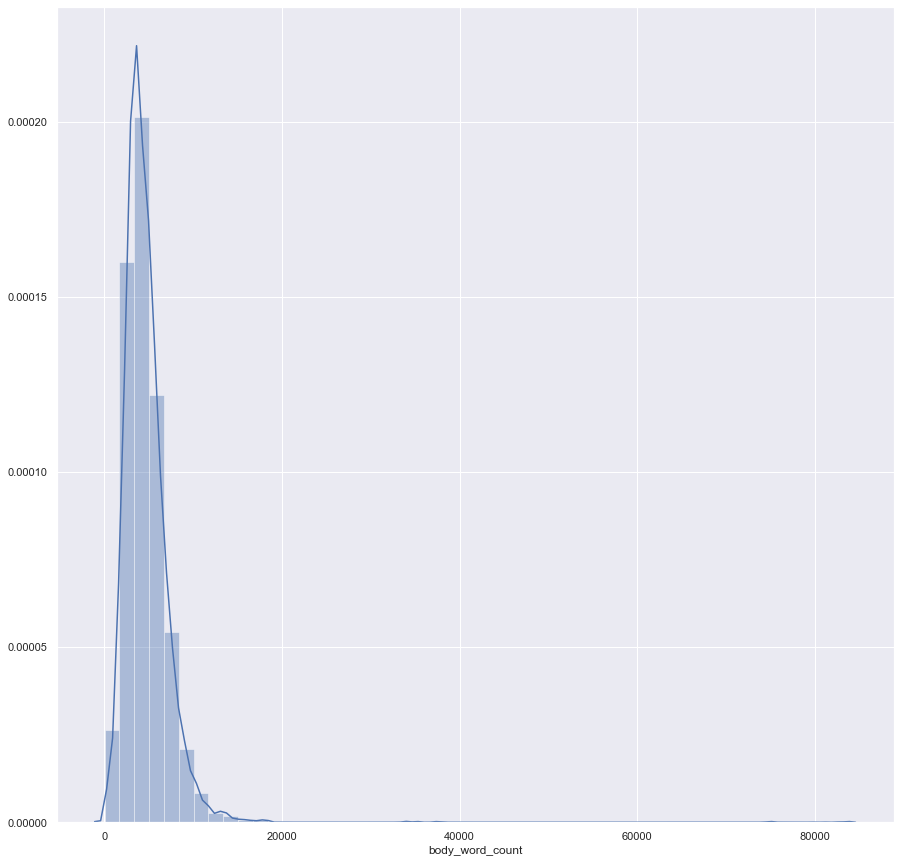

In [129]:
sns.distplot(test_df['body_word_count'])
test_df['body_word_count'].describe()

count     5000.000000
mean      1444.171800
std        581.362861
min         47.000000
25%       1099.000000
50%       1366.000000
75%       1713.250000
max      14179.000000
Name: body_unique_words, dtype: float64

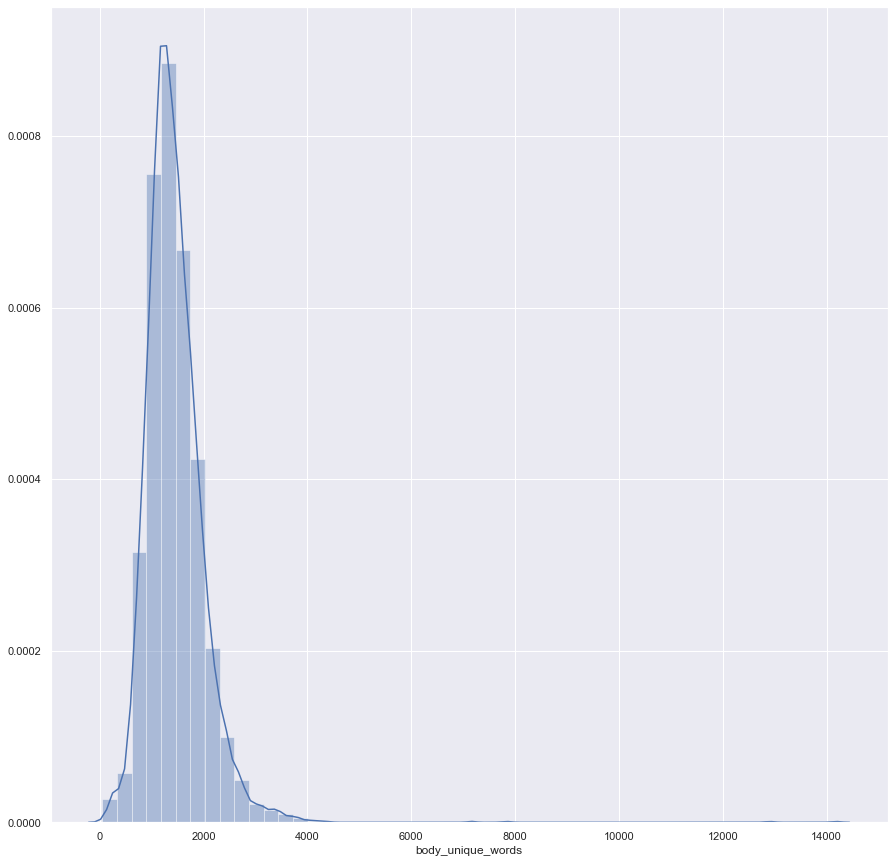

In [130]:
sns.distplot(test_df['body_unique_words'])
test_df['body_unique_words'].describe()

In [131]:
test_df['processed_text']

1053    introduction human constantly expose myriad pa...
1054    pathogens vector transport rapidly world conse...
1055    a1111111111 a1111111111 a1111111111 a111111111...
1056    addition preventative care nutritional support...
1057    ubiquitination widely use posttranslational mo...
                              ...                        
6466    facing emergence severe acute respiratory synd...
6467    inclusion criterium asymptomatic adult absence...
6468    noroviruses evolutionarily diverse group singl...
6469    respiratory syncytial virus rsv major cause lo...
6470    coronaviruses covs infect wide variety animal ...
Name: processed_text, Length: 5000, dtype: object